In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

from tqdm import tqdm
from sklearn import datasets

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [3]:
from sklearn import tree

In [4]:
from nflib import coupling_flows as cf
from nflib import flows as nf
from nflib import res_flow as rf

## 2D regression dataset

In [5]:
num_points = 100
# X1 = np.linspace(-2.5, 1.9, num_points)
X1 = np.linspace(-2.5, 2.5, num_points)
X2 = np.linspace(-2.5, 3, num_points)
# X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)

Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)
# Y = np.sqrt(X1**2 + X2**2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

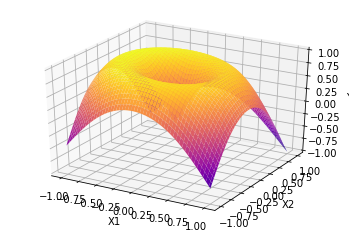

In [6]:
x1 = X1.reshape(-1)
x2 = X2.reshape(-1)
y = Y.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

## Linear - Split data to Maximize Information Gain

In [265]:
class LeafNode(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.constant = nn.Parameter(torch.zeros(output_dim)+torch.randn(output_dim)*0.1)
        
    def forward(self, x):
        return self.constant.expand(x.shape[0], self.constant.shape[0])
    
    
# class LeafNode(nn.Module):
    
#     def __init__(self, input_dim, output_dim):
#         super().__init__()
#         self.linear = nn.Linear(input_dim, output_dim)
#         self.linear.weight.data *= 0.001
        
#     def forward(self, x):
#         return self.linear(x)
    
    
class DecisionNode(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Linear(input_dim, 1)
#         self.linear.weight.data *= 0
        self.hardness = 1.0
        self.node0, self.node1 = None, None
        
    def forward(self, x):
        norms = torch.norm(self.linear.weight.data, dim=1, keepdim=True)
        self.linear.weight.data /= norms 

        mask = torch.sigmoid(self.linear(x)*(2**self.hardness))
        out0 = self.node0(x)
        out1 = self.node1(x)
        return out0*mask + out1*(1-mask)
        
    def create_child(self, depth):
        if depth > 1:
            self.node0 = DecisionNode(self.input_dim, self.output_dim)
            self.node1 = DecisionNode(self.input_dim, self.output_dim)
            self.node0.create_child(depth-1)
            self.node1.create_child(depth-1)
        else:
            self.node0 = LeafNode(self.input_dim, self.output_dim)
            self.node1 = LeafNode(self.input_dim, self.output_dim)
            
    def set_hardness(self, hardness):
        self.hardness = hardness
#         with torch.no_grad():
#             self.hardness = hardness
#             norms = torch.norm(self.linear.weight.data, dim=1, keepdim=True)
#             factor = hardness/norms
#             self.linear.weight.data *= factor 
#             self.linear.bias.data *= factor.reshape(-1)
        if isinstance(self.node0, DecisionNode):
            self.node0.set_hardness(hardness)
        if isinstance(self.node1, DecisionNode):
            self.node1.set_hardness(hardness)
        return

In [266]:
class ST_Sigmoid(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, x):
        zz = 1/(1+torch.exp(-x))
        ctx.save_for_backward(zz)
        
        output = (x>0).type(x.dtype)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        zz, = ctx.saved_tensors
        grad_x = None
        
        if ctx.needs_input_grad[0]:
            grad_x = zz*(1-zz)*grad_output

        return grad_x

In [267]:
class DistanceBinary(nn.Module):
    def __init__(self, input_dim, inv_temp=1):
        super().__init__()
        self.centers = nn.Parameter(torch.rand(1, input_dim)*2-1)
        self.bias = nn.Parameter(torch.ones(1)*-0.5)
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
    def forward(self, x):
        x = torch.norm(x-self.centers, dim=1, keepdim=True) + self.bias
        return x

In [268]:
class InvexMLP_Generator(cf.FuncGenerator):
    
    def __init__(self, hidden_dims=[], activation=rf.Swish):
        super().__init__()
        self.hidden_dims = hidden_dims
        self.activation = activation
        
    def generate(self, input_dim, output_dim):
        layers = [nf.ActNorm(input_dim)]
    
        for hd in self.hidden_dims:
            if isinstance(hd, (list, tuple)):
                a = rf.ResidualFlow(input_dim, hd, self.activation)
            else:
                a = rf.ResidualFlow(input_dim, [hd], self.activation)
            b = nf.ActNorm(input_dim)
            layers += [a, b]
#         print(layers)
        model = nf.SequentialFlow(layers)
        classifier = DistanceBinary(input_dim)
        return nn.Sequential(model, classifier)
    
    
class MLP_Generator(cf.FuncGenerator):

    def __init__(self, hidden_dims=[], activation=nn.LeakyReLU(0.2)):
        super().__init__()
        self.hidden_dims = hidden_dims
        self.activation = activation

    def generate(self, input_dim, output_dim):
        dims = [input_dim, *self.hidden_dims]
        layers = []
        for i in range(len(dims)-1):
            a = nn.utils.spectral_norm(nn.Linear(dims[i], dims[i+1]))
            b = self.activation
            layers += [a, b]
        fl = nn.utils.spectral_norm(nn.Linear(dims[-1], output_dim))
#         fl.weight.data *= 0.
        layers.append(fl)
        return nn.Sequential(*layers)
    

class DecisionNode(nn.Module):
    
    def __init__(self, input_dim, output_dim, split_func:cf.FuncGenerator()):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
#         self.linear = nn.Linear(input_dim, 1)
        self.linear = split_func.generate(input_dim, output_dim)
    
        self.sigmoid = ST_Sigmoid.apply
#         self.sigmoid = nn.Sigmoid()
        #         self.linear.weight.data *= 0
        self.hardness = 0
        self.node0, self.node1 = None, None
        
    def forward(self, x):
#         norms = torch.norm(self.linear.weight.data, dim=1, keepdim=True)
#         self.linear.weight.data /= norms 
        mask = self.linear(x)
#         self.push_loss = torch.exp(-((mask-0.5)*8)**2).mean()
        ## to minimize the points on the decision boundary:
        ## push the outputs such that gradient around 0 is high
        
#         mask_ = torch.sigmoid(mask)
#         self.push_loss = torch.exp(-((mask-0.5)*4)**2).mean()*0.1
#         self.push_loss = -0.5*torch.mean(torch.log(mask_)+torch.log(1-mask_))*0.1
#         mask = mask*(2**self.hardness)
        mask = self.sigmoid(mask)
#         print(mask)
        
        out0 = self.node0(x)
        out1 = self.node1(x)
        return out0*mask + out1*(1-mask)
        
    def create_child(self, depth):
        if depth > 1:
            self.node0 = DecisionNode(self.input_dim, self.output_dim)
            self.node1 = DecisionNode(self.input_dim, self.output_dim)
            self.node0.create_child(depth-1)
            self.node1.create_child(depth-1)
        else:
            self.node0 = LeafNode(self.input_dim, self.output_dim)
            self.node1 = LeafNode(self.input_dim, self.output_dim)
            
    def set_hardness(self, hardness):
        self.hardness = hardness
#         with torch.no_grad():
#             self.hardness = hardness
#             norms = torch.norm(self.linear.weight.data, dim=1, keepdim=True)
#             factor = hardness/norms
#             self.linear.weight.data *= factor 
#             self.linear.bias.data *= factor.reshape(-1)
        if isinstance(self.node0, DecisionNode):
            self.node0.set_hardness(hardness)
        if isinstance(self.node1, DecisionNode):
            self.node1.set_hardness(hardness)
        return

In [280]:
# mlpgen = MLP_Generator([10], nn.ELU())
mlpgen = cf.MLP_Generator([10], nn.ELU())
# mlpgen = InvexMLP_Generator([10])
# mlpgen = MLP_Generator()

In [281]:
model = DecisionNode(2, 1, mlpgen)
model.create_child(1)

In [282]:
yout = model(xx)
yout

tensor([[0.0012],
        [0.0012],
        [0.0012],
        ...,
        [0.0012],
        [0.0012],
        [0.0012]], grad_fn=<AddBackward0>)

In [283]:
model

DecisionNode(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
  (node0): LeafNode()
  (node1): LeafNode()
)

In [284]:
# model.linear[0].weight

In [285]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.5439, -0.0935],
         [ 0.1268,  0.1889],
         [ 0.4867, -0.0343],
         [ 0.6608, -0.3962],
         [-0.0761, -0.1459],
         [ 0.6266,  0.6597],
         [-0.3050, -0.4343],
         [-0.5511,  0.4584],
         [ 0.2367,  0.2357],
         [-0.1196, -0.0686]], requires_grad=True), Parameter containing:
 tensor([ 0.2328, -0.5318,  0.4585, -0.1751, -0.5967, -0.5561,  0.1601, -0.1011,
         -0.4217,  0.4052], requires_grad=True), Parameter containing:
 tensor([[0., 0., 0., -0., -0., 0., -0., 0., -0., 0.]], requires_grad=True), Parameter containing:
 tensor([-0.2341], requires_grad=True), Parameter containing:
 tensor([-0.1699], requires_grad=True), Parameter containing:
 tensor([0.0012], requires_grad=True)]

In [286]:
yout.shape

torch.Size([10000, 1])

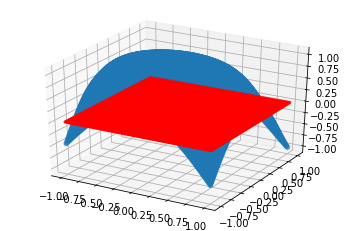

In [287]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
plt.pause(0.1)
plt.show()

In [288]:
yout = model(xx)

In [289]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0031)
criterion = nn.MSELoss()

In [290]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

hardness = 0
model.set_hardness(hardness)
for epoch in range(10000):

    yout = model(xx)
    loss = criterion(yout, yy) #+ model.push_loss
    optimizer.zero_grad()
    loss.backward()
#     if epoch>3000:
#         model.linear.zero_grad()
    optimizer.step()
    
#     if (epoch+1)%1000 == 0:
#         hardness += 1
#         model.set_hardness(hardness)
    
    if epoch%200 == 0:
#         fig = plt.figure(figsize=(9,8))
#         ax = fig.gca(projection='3d')

        error = float(loss)
        print(f'Epoch:{epoch} | Error:{error}')
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        yout_ = yout.data.reshape(Y.shape)
        ax.scatter(X1, X2, yout_, color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
#         plt.show()

Epoch:0 | Error:0.4342587888240814
Epoch:200 | Error:0.1258091926574707
Epoch:400 | Error:0.09230173379182816
Epoch:600 | Error:0.08082437515258789
Epoch:800 | Error:0.07306995242834091
Epoch:1000 | Error:0.06592945754528046
Epoch:1200 | Error:0.06344399601221085
Epoch:1400 | Error:0.06240840628743172
Epoch:1600 | Error:0.061676234006881714
Epoch:1800 | Error:0.061204664409160614
Epoch:2000 | Error:0.06083744391798973
Epoch:2200 | Error:0.06072277948260307
Epoch:2400 | Error:0.05235724523663521
Epoch:2600 | Error:0.05072353035211563
Epoch:2800 | Error:0.050450898706912994
Epoch:3000 | Error:0.05037423223257065
Epoch:3200 | Error:0.050340741872787476
Epoch:3400 | Error:0.05034798011183739
Epoch:3600 | Error:0.05032751336693764
Epoch:3800 | Error:0.050357405096292496
Epoch:4000 | Error:0.05037620663642883
Epoch:4200 | Error:0.05036937817931175
Epoch:4400 | Error:0.050433289259672165
Epoch:4600 | Error:0.05041104555130005
Epoch:4800 | Error:0.05048371106386185
Epoch:5000 | Error:0.0504878

TclError: invalid command name "."

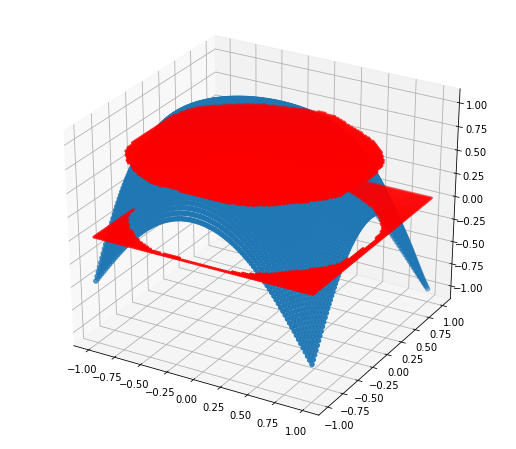

In [291]:
%matplotlib inline
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
plt.show()

In [20]:
torch.sigmoid(model.linear(xx)).data.tolist()

[[0.11460067331790924],
 [0.11759234219789505],
 [0.1208009347319603],
 [0.124238021671772],
 [0.1278715878725052],
 [0.1316767930984497],
 [0.13565970957279205],
 [0.13982638716697693],
 [0.1441834270954132],
 [0.14873751997947693],
 [0.15349578857421875],
 [0.15846556425094604],
 [0.1636425107717514],
 [0.16897356510162354],
 [0.17445045709609985],
 [0.18007256090641022],
 [0.18583837151527405],
 [0.19174635410308838],
 [0.19779449701309204],
 [0.2039802074432373],
 [0.21030063927173615],
 [0.21675240993499756],
 [0.22333161532878876],
 [0.23003390431404114],
 [0.23685432970523834],
 [0.24378742277622223],
 [0.25082728266716003],
 [0.25796711444854736],
 [0.26520007848739624],
 [0.2725181579589844],
 [0.27991315722465515],
 [0.287376344203949],
 [0.29489779472351074],
 [0.30246785283088684],
 [0.3100753426551819],
 [0.317709356546402],
 [0.32535797357559204],
 [0.33300837874412537],
 [0.3406478464603424],
 [0.348262757062912],
 [0.35583898425102234],
 [0.363361656665802],
 [0.3708157

### Tree with Invex Clusters